# Neural Nets with Keras - Part 1 : Time series

## Introduction and data generation

This first part of the tutorial will focus on simple Artificial Neural Networks.

We will try to predict time series (continuous signals) using simple architectures.

The notation are taken from the really [good introduction](https://www.youtube.com/playlist?list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH) from Hugo Larochelle.

The explanations are minimal and this intro should be considered as a starting point for working with [keras](http://keras.io/).

let $y_t$ be the value of the signal at time $t=1,\dots, 100000$

Suppose that we want to study a time series following this process:
    $$y_t = 40+10^{-5}t+10^{-9}t^2+\sin(0.2\pi\frac{t}{0.8})+\sin(0.5\pi\frac{t}{4})$$
    
We can easily generate this data with numpy:

In [1]:
import numpy as np
np.random.seed(1332)


sample = 100000
Fs = 80
f = 5
time = np.arange(sample)

y_t = 40 + 4e-5*time+2e-9*time**2 + np.sin((0.2 * np.pi * f * time)/ Fs/100) + np.sin((0.5*np.pi * f * time) / Fs / 20)


Graphically we have a nice sinusoidal function:

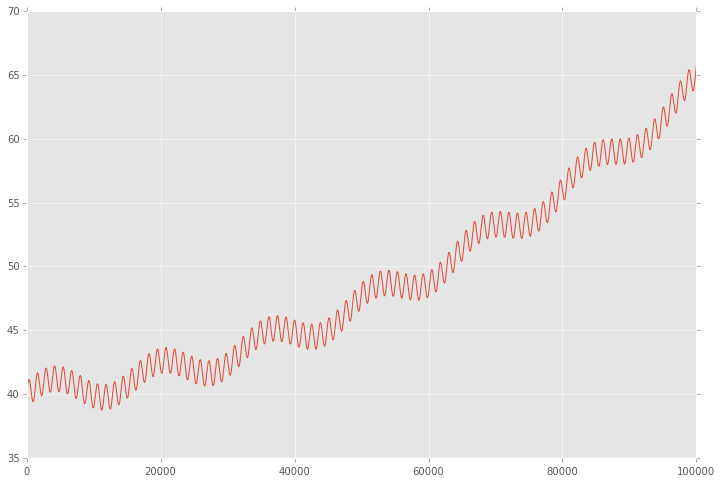

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.plot(y_t[:])
plt.show()

The process is :
1. nonlinear
2. not stationary because we see cycles and seasonnality

Let's try a simple neural net with a single hidden layer on this data.

We define:

- the hidden layers pre-activation:

$$a(t)_i = b_i^{(1)} + W_i^{(1)}t$$

- the hidden layers activation:

$$h(t)_i = g(a(t)_i)$$

- the output layer activation:

$$f(t) = o(b^{(2)} + w_i^{(2)}h^{(1)}(t)_i)$$

Where we want $f(t)$ as close as possible to $y_t$

Here we will build a hidden layer with 10 units the hidden layer activation function $g()$ is a sigmoid and the output layer activation function is linear.

In [3]:
import theano
import keras
from keras.models import Graph
from keras.layers.core import Dense
from keras.optimizers import Adam, SGD


model = Graph()
model.add_input(name='exog', input_shape=(1,))
model.add_node(Dense(10, activation="sigmoid"), name='dense1', input='exog')
model.add_node(Dense(1, activation="linear"), name='last_dense', input='dense1')
model.add_output(name='output', input='last_dense')
sgd = SGD(lr=1e-3, decay=1e-7, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss={'output':'mse'})

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 980 (CNMeM is disabled)


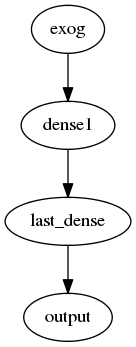

In [4]:
from IPython.display import Image
from keras.utils.visualize_util import to_graph

Image(to_graph(model).create(prog='dot', format='png'))

In [5]:
print([np.prod(p.shape.eval()) for p in model.params])
print(model.count_params())

[10, 10, 10, 1]
31


We have 31 parameters in total:
- 10 weights and 10 intercepts for the 1st layer
- 10 weights and 1 intercept for the hidden layer

In [6]:
time = (time - time.mean())/time.std()

We scale the exogenous variable so the optimization technique we use [converge quickly](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf).

In [7]:
estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

Early stopping is used to stop the learning before the end if the perfmormance decreases on the validation set.

In [8]:
history = model.fit({'exog': time[:-30000,None], 'output': y_t[:-30000]},
          validation_data={'exog':time[-30000:, None], 'output': y_t[-30000:]},
          batch_size=32,
          nb_epoch=60,
          callbacks=[estop])

Train on 70000 samples, validate on 30000 samples
Epoch 1/60
70000/70000 [==============================] - 2s - loss: 11.1253 - val_loss: 22.7605
Epoch 2/60
70000/70000 [==============================] - 2s - loss: 1.0445 - val_loss: 17.4443
Epoch 3/60
70000/70000 [==============================] - 2s - loss: 1.0256 - val_loss: 13.9486
Epoch 4/60
70000/70000 [==============================] - 2s - loss: 1.0138 - val_loss: 11.5464
Epoch 5/60
70000/70000 [==============================] - 2s - loss: 1.0032 - val_loss: 10.1619
Epoch 6/60
70000/70000 [==============================] - 2s - loss: 0.9936 - val_loss: 9.0533
Epoch 7/60
70000/70000 [==============================] - 2s - loss: 0.9850 - val_loss: 8.0686
Epoch 8/60
70000/70000 [==============================] - 2s - loss: 0.9788 - val_loss: 7.2505
Epoch 9/60
70000/70000 [==============================] - 2s - loss: 0.9737 - val_loss: 6.7114
Epoch 10/60
70000/70000 [==============================] - 2s - loss: 0.9707 - val_loss: 

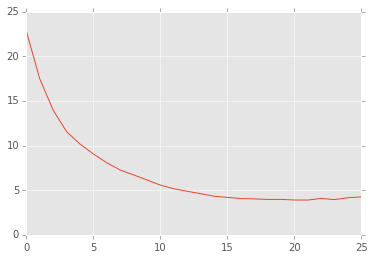

In [9]:
plt.plot(history.history["val_loss"])
plt.show()

1.73449963832


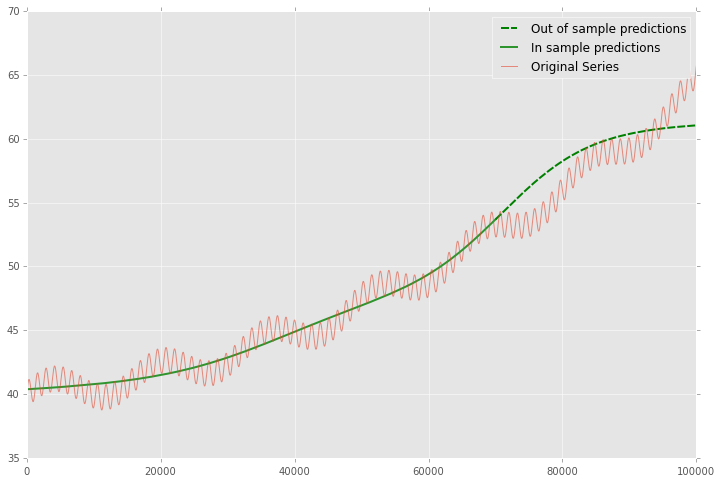

In [10]:
predictions_oos = model.predict({'exog': time[-30000:,None]}, batch_size=128)
predictions_is = model.predict({'exog': time[:-30000,None]}, batch_size=128)
predictionsg_oos = np.concatenate([np.array([np.nan for el in range(70000)]), predictions_oos["output"].flatten()])
predictionsg_is = np.concatenate([predictions_is["output"].flatten(), np.array([np.nan for el in range(30000)])])

fig = plt.figure(figsize=(12,8))
print(np.sqrt((predictions_oos["output"].flatten()-y_t[-30000:])**2).mean())
plt.plot(predictionsg_oos, color="green", dashes=[8,2], linewidth=2, label="Out of sample predictions")
plt.plot(predictionsg_is, color="green", alpha=0.8, linewidth=2, label="In sample predictions")
plt.plot(y_t, alpha=0.6, label="Original Series")
plt.legend()
plt.show()

We can fit the trend in the training set but the validation performance is not crazy.
Let's add some regularization on the parameters. We choose a L1 norm [regularization]((http://davidrosenberg.github.io/ml2015/docs/2b.L1L2-regularization.pdf) to have a sparse structure in the model.

In [11]:
from keras.regularizers import l1l2, l1

model = Graph()
model.add_input(name='exog', input_shape=(1,))
model.add_node(Dense(10, activation="sigmoid",  W_regularizer=l1(0.05)), name='dense1', input='exog')
model.add_node(Dense(1, activation="linear", W_regularizer=l1(0.001)), name='last_dense', input='dense1')
model.add_output(name='output', input='last_dense')
sgd = SGD(lr=1e-3, decay=1e-7, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss={'output':'mse'})

In [12]:
estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = model.fit({'exog': time[:-30000,None], 'output': y_t[:-30000]},
          validation_data={'exog':time[-30000:, None], 'output': y_t[-30000:]},
          batch_size=32,
          nb_epoch=40,
          callbacks=[estop])

Train on 70000 samples, validate on 30000 samples
Epoch 1/40
70000/70000 [==============================] - 3s - loss: 11.4645 - val_loss: 19.4046
Epoch 2/40
70000/70000 [==============================] - 3s - loss: 1.4300 - val_loss: 13.7981
Epoch 3/40
70000/70000 [==============================] - 3s - loss: 1.3972 - val_loss: 11.2909
Epoch 4/40
70000/70000 [==============================] - 3s - loss: 1.3780 - val_loss: 9.6041
Epoch 5/40
70000/70000 [==============================] - 3s - loss: 1.3647 - val_loss: 8.0017
Epoch 6/40
70000/70000 [==============================] - 3s - loss: 1.3539 - val_loss: 7.1387
Epoch 7/40
70000/70000 [==============================] - 3s - loss: 1.3454 - val_loss: 6.4639
Epoch 8/40
70000/70000 [==============================] - 3s - loss: 1.3389 - val_loss: 6.5241
Epoch 9/40
70000/70000 [==============================] - 3s - loss: 1.3317 - val_loss: 5.9667
Epoch 10/40
70000/70000 [==============================] - 3s - loss: 1.3252 - val_loss: 6.

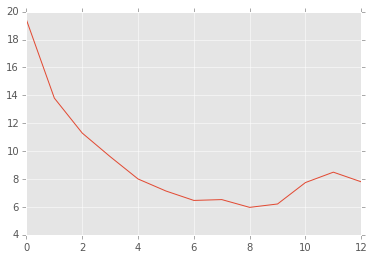

In [13]:
plt.plot(history.history["val_loss"])
plt.show()

2.23475575662


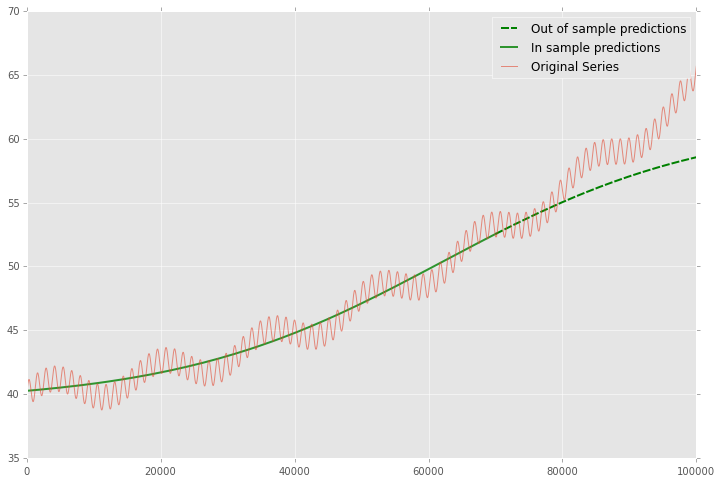

In [14]:
predictions_oos = model.predict({'exog': time[-30000:,None]}, batch_size=128)
predictions_is = model.predict({'exog': time[:-30000,None]}, batch_size=128)
predictionsg_oos = np.concatenate([np.array([np.nan for el in range(70000)]), predictions_oos["output"].flatten()])
predictionsg_is = np.concatenate([predictions_is["output"].flatten(), np.array([np.nan for el in range(30000)])])

fig = plt.figure(figsize=(12,8))
print(np.sqrt((predictions_oos["output"].flatten()-y_t[-30000:])**2).mean())
plt.plot(predictionsg_oos, color="green", dashes=[8,2], linewidth=2, label="Out of sample predictions")
plt.plot(predictionsg_is, color="green", alpha=0.8, linewidth=2, label="In sample predictions")
plt.plot(y_t, alpha=0.6, label="Original Series")
plt.legend()
plt.show()

It seems reasonnable to add some regularization since we capture the quadratic trend with more accuracy.

# Using an AR structure for one step ahead predictions

Because we have seasonnality and cycles in our data, we could try to use lags of the time series to capture the recurrent patterns.

To do so, we crop some patches out of our time series.

In [15]:
from sklearn.feature_extraction.image import extract_patches_2d

len_ts_y = 60

data_patched = extract_patches_2d(y_t[:,None], (len_ts_y,1))
y_train = data_patched[:,-1,-1]
endog_train = data_patched[:,-len_ts_y-1:-1,-1]
mean, std = endog_train.mean(axis=0), endog_train.std(axis=0)

We use past data to predict the current valeur of our variable $y_t$. $y_{t-1}, \dots, y_{t-59}$ are used in the model so we can only begin to predict from $y_{60}$

In [16]:
endog_train.shape

(99941, 59)

In [17]:
endog_train = (endog_train-endog_train.mean(axis=0))/endog_train.std(axis=0)

The data is also rescaled as time in our first model.

In [18]:
model = Graph()
model.add_input(name='endog', input_shape=(59,))
model.add_node(Dense(10, activation="sigmoid"), name='dense1', input='endog')
model.add_node(Dense(1, activation="linear"), name='last_dense', input='dense1')
model.add_output(name='output', input='last_dense')
sgd = SGD(lr=1.4e-3, decay=1e-9, momentum=0.85, nesterov=True)

model.compile(optimizer=sgd, loss={'output':'mse'})

In [19]:
estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = model.fit({'endog': endog_train[:-30000].reshape(-1,59), 'output': y_t[:-30000]},
          validation_data={'endog':endog_train[-30000:].reshape(-1,59), 'output': y_t[-30000:]},
          batch_size=32,
          nb_epoch=400,
          callbacks=[estop],
          verbose=0)

**[EDIT]:** I stopped the optimization really soon on my first try. I added 370 iterations so we could end up near a local optimum.

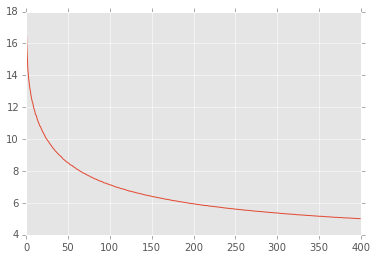

In [20]:
plt.plot(history.history["val_loss"])
plt.show()

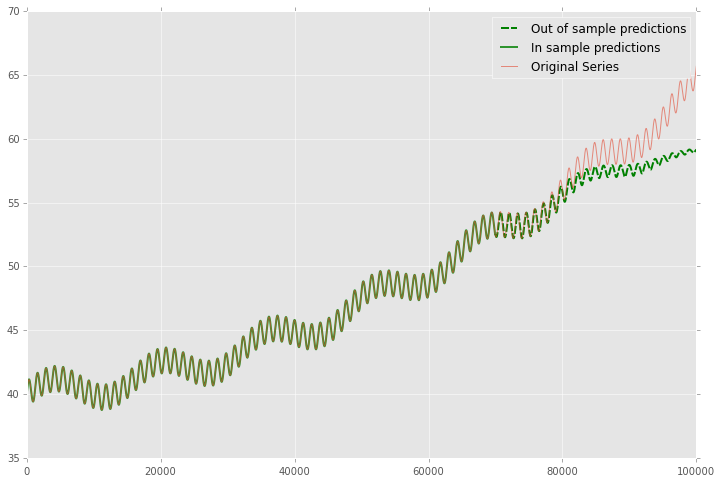

In [21]:
predictions_oos = model.predict({'endog': endog_train[-30000:].reshape(-1,59)}, batch_size=128)
predictions_is = model.predict({'endog': endog_train[:-30000].reshape(-1,59)}, batch_size=128)
predictionsg_oos = np.concatenate([np.array([np.nan for el in range(70000)]), predictions_oos["output"].flatten()])
predictionsg_is = np.concatenate([predictions_is["output"].flatten(), np.array([np.nan for el in range(30000)])])

fig = plt.figure(figsize=(12,8))
plt.plot(predictionsg_oos, color="green", dashes=[8,2], linewidth=2, label="Out of sample predictions")
plt.plot(predictionsg_is, color="green", alpha=0.8, linewidth=2, label="In sample predictions")
plt.plot(y_t, alpha=0.6, label="Original Series")
plt.legend()
plt.show()

The prediction is much more accurate even on the first periods of the out of sample prediction.

We should be good to go for more fun stuff in the next parts!

![Chuck](https://heavyeditorial.files.wordpress.com/2012/09/tapyy.gif?w=780)